## Framing the Problem

This explores the game of Orlog from Assassin's Creed: Valhalla, in search of an optimal policy for winning games.

In the very short description, we can probably approach this as a state table with a Q-learning approach. We treat the game as an MDP since prior turns in the game do not change what information we gain about the game's progress when we know the current turn. Each game (multiple turns) is a single episode. Games are short (there are few state changes) so we can update the policy at the end of each episode - needn't look into temporal difference approaches.

To make the development on the game and algorithm fast, we can simplify the game down to the core pieces:

1. Player flips a coin to determine who goes first.
1. Player rolls a single dice up to three times and chooses which roll result they want to keep.
1. Opponent does the same.
1. Resolution occurs.
1. If there is health on both sides of the game, repeat previous three steps. Else, player with health remaining is the winner.
1. Policy is updated based on which moves resulted in a win and which resulted in a loss.
1. Repeat until a policy is developed that consistently wins games better than random strategy.

TODO:

* ~~Create game representation.~~
* ~~Create random strategy.~~
* ~~Pull metrics on win/loss rate for random strategy. This serves as the baseline.~~
* Review algorithms available to us and pass the game representation into one.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from enum import Enum, auto

import torch
import torch.nn as nn

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
logging.debug(f'DEBUG logging enabled!')

DEBUG:root:DEBUG logging enabled!


In [3]:
def flip_coin():
    """
    1 is heads, 0 is tails.
    """
    return random.randint(0,1)

In [4]:
class DieFacing(Enum):
    SWORD = 1
    SHIELD = 2
    ARROW = 3
    HELMET = 4
    STEAL = 5
    FAVOUR = 6

In [89]:
def random_dice_keeping_strategy(roll_results: list):
    """
    Randomly decide which rolls to keep.
    """
    keep_rolls = []
    for result in roll_results:
        if random.randint(0,1) > 0:
            keep_rolls.append(result)
    logging.debug(f'Dice keeping strategy: Random. Keeping {len(keep_rolls)}/{len(roll_results)}')
    return keep_rolls


def steadfast_dice_keeping_strategy(roll_results: list):
    """Always keep all rolls."""
    logging.debug(f'Dice keeping strategy: Steadfast. Keeping {len(roll_results)}')
    return roll_results

In [181]:
class OrlogGame(object):
    def __init__(
        self, 
        player_strategy = steadfast_dice_keeping_strategy, 
        opponent_strategy = random_dice_keeping_strategy
    ):
        self.current_turn = 0
        self.die_per_turn = 2
        self.max_rolls = 3
        self.max_turns = 100  # TODO Just a failsafe. Implement.
        self.player_strategy = player_strategy
        self.opponent_strategy = opponent_strategy
        self.player_health = 10
        self.player_favour = 0
        self.opponent_health = 10
        self.opponent_favour = 0
        self.game_ended = -1
    
    def describe_game_state() -> dict:
        # TODO Impl
        return
    
    def roll_dice(self, die: int):
        die_results = []
        for dice in range(die):
            result = DieFacing(random.randint(1,len(DieFacing)))
            logging.debug(f'Roll result: {result}')
            die_results.append(result)
        return die_results
    
    def roll_and_select(self, die: int, strategy):
        roll_results = self.roll_dice(die)
        kept_results = strategy(roll_results)
        return kept_results, roll_results
    
    def run_turn(self, strategy):
        kept_rolls = []
        for i in range(self.max_rolls):
            remaining_die = self.die_per_turn - len(kept_rolls)
            if remaining_die < 1:
                logging.debug(f'No more die to roll. Moving on.')
                break
            logging.debug(f'Dice roll {i+1}/{self.max_rolls}. Remaining die: {remaining_die}')
            current_kept_rolls, all_rolls = self.roll_and_select(die=remaining_die, strategy=strategy)
            logging.debug(f'all_rolls: {all_rolls}')
            logging.debug(f'current_kept_rolls: {current_kept_rolls}')
            
            # If we're on the last roll, must keep all remaining die - otherwise, keep all that were selected.
            if i+1 >= self.max_rolls:
                logging.debug(f'We are now on the {i+1}th roll, this was the final roll - keeping remaining die: {all_rolls}')
                kept_rolls += all_rolls
                break
            else:
                kept_rolls += current_kept_rolls
            logging.debug(f'Kept rolls now up to: {kept_rolls}')
        return kept_rolls
    
    @staticmethod
    def dice_to_stats(rolls: list):
        """
        Given a list of enums, determine the total melee damage, total melee defense, etc.
        """
        def __count_of(facing: DieFacing, rolls):
            return sum([1 for x in filter(lambda x: facing == x, rolls)])
        
        # Python doesn't have case statements, so we do this instead. This wouldn't scale 
        # to millions of rolls - but that's fine, actual game only has 6 die per player per turn.
        attack = __count_of(DieFacing.SWORD, rolls)
        defense = __count_of(DieFacing.SHIELD, rolls)
        rattack = __count_of(DieFacing.ARROW, rolls)
        rdefense = __count_of(DieFacing.HELMET, rolls)
        new_favour = __count_of(DieFacing.FAVOUR, rolls)
        steal_favour = __count_of(DieFacing.STEAL, rolls)
        logging.debug(f'dice_to_stats produced: {[attack, defense, rattack, rdefense, new_favour, steal_favour]}')
        return attack, defense, rattack, rdefense, new_favour, steal_favour

    def resolution(self, player_rolls: list, opponent_rolls: list):
        logging.debug(f'Resolution has begun!')
        logging.debug(f'Player has rolled: {player_rolls}')
        logging.debug(f'Opponent has rolled: {opponent_rolls}')
        
        # Deal damage.
        player_atk, player_def, player_ratk, player_rdef, player_new_favour, player_steal_favour = \
            OrlogGame.dice_to_stats(player_rolls)
        opp_atk, opp_def, opp_ratk, opp_rdef, opp_new_favour, opp_steal_favour = \
            OrlogGame.dice_to_stats(opponent_rolls)
        melee_dmg_to_player = max(0, opp_atk - player_def)  # TODO Confirm this is the correct processing.
        range_dmg_to_player = max(0, opp_ratk - player_rdef)
        melee_dmg_to_opp = max(0, player_atk - opp_def)
        range_dmg_to_opp = max(0, player_ratk - opp_rdef)
        logging.debug(f'melee_dmg_to_player: {melee_dmg_to_player}')
        logging.debug(f'range_dmg_to_player: {range_dmg_to_player}')
        logging.debug(f'melee_dmg_to_opp: {melee_dmg_to_opp}')
        logging.debug(f'range_dmg_to_opp: {range_dmg_to_opp}')
        self.player_favour += player_new_favour
        self.opponent_favour += opp_new_favour
        logging.debug(f'Player gained {player_new_favour} new favour.')
        logging.debug(f'Opponent gained {opp_new_favour} new favour.')
        
        # Steal favour.
        if self.opponent_favour > 0:
            # Player can steal.
            player_steals = min(player_steal_favour, self.opponent_favour)
            self.opponent_favour -= player_steals
            self.player_favour += player_steals
            logging.debug(f'Player stole {player_steals} favour from opponent!')
        if self.player_favour > 0:
            # Opp can steal.
            opp_steals = min(opp_steal_favour, self.player_favour)
            self.player_favour -= opp_steals
            self.opponent_favour += opp_steals
            logging.debug(f'Opponent stole {opp_steals} favour from player!')
        
        total_damage_to_player = melee_dmg_to_player + range_dmg_to_player
        total_damage_to_opponent = melee_dmg_to_opp + range_dmg_to_opp
        self.player_health -= total_damage_to_player
        self.opponent_health -= total_damage_to_opponent
        logging.debug(f'total_damage_to_player: {total_damage_to_player}')
        logging.debug(f'total_damage_to_opponent: {total_damage_to_opponent}')
        
        # Did someone win?
        logging.info(f'Player health: {self.player_health}, Opponent health: {self.opponent_health}')
        logging.info(f'Player favour: {self.player_favour}, Opponent favour: {self.opponent_favour}')
        if self.player_health <= 0 and self.opponent_health <= 0:
            logging.info(f'Stalemate - both players lost? Was not aware that could happen!')
            return 2
        elif self.player_health <= 0:
            logging.info(f'Opponent won!')
            return 0
        elif self.opponent_health <= 0:
            logging.info(f'Player won!')
            return 1
        else:
            logging.info(f'Neither player has won yet.')
            return -1
    
    def run(self):
        if self.game_ended >= 0:
            raise ValueError(f'Game already completed with result: {self.game_ended} after {self.current_turn} turns.')
        coinflip = flip_coin()
        logging.info(f'Coinflip was: {coinflip}')
        for i in range(self.max_turns):
            logging.info(f'Turn {i+1} begins.')
            self.current_turn += 1
            if coinflip:
                logging.info('Player goes first.')
                player_turn = self.run_turn(strategy=self.player_strategy)
                logging.debug(f'Now opponent takes their turn.')
                opponent_turn = self.run_turn(strategy=self.opponent_strategy)
            else:
                logging.info('Opponent goes first.')
                opponent_turn = self.run_turn(strategy=self.opponent_strategy)
                logging.debug(f'Now player takes their turn.')
                player_turn = self.run_turn(strategy=self.player_strategy)
            # Resolution
            # TODO The resolution probably cares about the turn order, just as the strategy does. 
            # Account for that here?
            self.game_ended = self.resolution(player_turn, opponent_turn)
            if self.game_ended == -1:
                logging.info(f'Moving on to next turn.\n\n')
            else:
                logging.info(f'Game has ended!')
                break
        return self.game_ended

In [178]:
# Test the game.
game = OrlogGame()

In [179]:
game.run()

INFO:root:Coinflip was: 0
INFO:root:Turn 1 begins.
INFO:root:Opponent goes first.
DEBUG:root:Dice roll 1/3. Remaining die: 2
DEBUG:root:Roll result: DieFacing.HELMET
DEBUG:root:Roll result: DieFacing.ARROW
DEBUG:root:Dice keeping strategy: Random. Keeping 2/2
DEBUG:root:all_rolls: [<DieFacing.HELMET: 4>, <DieFacing.ARROW: 3>]
DEBUG:root:current_kept_rolls: [<DieFacing.HELMET: 4>, <DieFacing.ARROW: 3>]
DEBUG:root:Kept rolls now up to: [<DieFacing.HELMET: 4>, <DieFacing.ARROW: 3>]
DEBUG:root:No more die to roll. Moving on.
DEBUG:root:Now player takes their turn.
DEBUG:root:Dice roll 1/3. Remaining die: 2
DEBUG:root:Roll result: DieFacing.FAVOUR
DEBUG:root:Roll result: DieFacing.FAVOUR
DEBUG:root:Dice keeping strategy: Steadfast. Keeping 2
DEBUG:root:all_rolls: [<DieFacing.FAVOUR: 6>, <DieFacing.FAVOUR: 6>]
DEBUG:root:current_kept_rolls: [<DieFacing.FAVOUR: 6>, <DieFacing.FAVOUR: 6>]
DEBUG:root:Kept rolls now up to: [<DieFacing.FAVOUR: 6>, <DieFacing.FAVOUR: 6>]
DEBUG:root:No more die to 

DEBUG:root:No more die to roll. Moving on.
DEBUG:root:Now player takes their turn.
DEBUG:root:Dice roll 1/3. Remaining die: 2
DEBUG:root:Roll result: DieFacing.STEAL
DEBUG:root:Roll result: DieFacing.FAVOUR
DEBUG:root:Dice keeping strategy: Steadfast. Keeping 2
DEBUG:root:all_rolls: [<DieFacing.STEAL: 5>, <DieFacing.FAVOUR: 6>]
DEBUG:root:current_kept_rolls: [<DieFacing.STEAL: 5>, <DieFacing.FAVOUR: 6>]
DEBUG:root:Kept rolls now up to: [<DieFacing.STEAL: 5>, <DieFacing.FAVOUR: 6>]
DEBUG:root:No more die to roll. Moving on.
DEBUG:root:Resolution has begun!
DEBUG:root:Player has rolled: [<DieFacing.STEAL: 5>, <DieFacing.FAVOUR: 6>]
DEBUG:root:Opponent has rolled: [<DieFacing.STEAL: 5>, <DieFacing.FAVOUR: 6>]
DEBUG:root:dice_to_stats produced: [0, 0, 0, 0, 1, 1]
DEBUG:root:dice_to_stats produced: [0, 0, 0, 0, 1, 1]
DEBUG:root:melee_dmg_to_player: 0
DEBUG:root:range_dmg_to_player: 0
DEBUG:root:melee_dmg_to_opp: 0
DEBUG:root:range_dmg_to_opp: 0
DEBUG:root:Player gained 1 new favour.
DEBUG:r

DEBUG:root:Kept rolls now up to: [<DieFacing.HELMET: 4>]
DEBUG:root:Dice roll 2/3. Remaining die: 1
DEBUG:root:Roll result: DieFacing.SHIELD
DEBUG:root:Dice keeping strategy: Random. Keeping 0/1
DEBUG:root:all_rolls: [<DieFacing.SHIELD: 2>]
DEBUG:root:current_kept_rolls: []
DEBUG:root:Kept rolls now up to: [<DieFacing.HELMET: 4>]
DEBUG:root:Dice roll 3/3. Remaining die: 1
DEBUG:root:Roll result: DieFacing.FAVOUR
DEBUG:root:Dice keeping strategy: Random. Keeping 1/1
DEBUG:root:all_rolls: [<DieFacing.FAVOUR: 6>]
DEBUG:root:current_kept_rolls: [<DieFacing.FAVOUR: 6>]
DEBUG:root:We are now on the 3th roll, this was the final roll - keeping remaining die: [<DieFacing.FAVOUR: 6>]
DEBUG:root:Now player takes their turn.
DEBUG:root:Dice roll 1/3. Remaining die: 2
DEBUG:root:Roll result: DieFacing.SWORD
DEBUG:root:Roll result: DieFacing.HELMET
DEBUG:root:Dice keeping strategy: Steadfast. Keeping 2
DEBUG:root:all_rolls: [<DieFacing.SWORD: 1>, <DieFacing.HELMET: 4>]
DEBUG:root:current_kept_rolls:

DEBUG:root:Opponent gained 1 new favour.
DEBUG:root:Player stole 0 favour from opponent!
DEBUG:root:Opponent stole 0 favour from player!
DEBUG:root:total_damage_to_player: 1
DEBUG:root:total_damage_to_opponent: 1
INFO:root:Player health: 0, Opponent health: 4
INFO:root:Player favour: 9, Opponent favour: 2
INFO:root:Opponent won!
INFO:root:Game has ended!


In [190]:
# Many games lol.
game_result_counts = {
    0: 0,  # Loss
    1: 0,  # Win
    2: 0,  # Draw
}
game_results = []

In [212]:
logging.getLogger().setLevel(logging.INFO)
for i in range(50):
    g = OrlogGame()
    game_result = g.run()
    game_results.append(game_result)
    game_result_counts[game_result] += 1

INFO:root:Coinflip was: 1
INFO:root:Turn 1 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Opponent health: 9
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 2 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Opponent health: 9
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 3 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Opponent health: 8
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 4 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Opponent health: 8
INFO:root:Player favour: 1, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Oppo

INFO:root:Game has ended!
INFO:root:Coinflip was: 0
INFO:root:Turn 1 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 10
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 2 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 9, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 3 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 8, Opponent health: 8
INFO:root:Player favour: 0, Opponent favour: 2
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 4 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 8, Opponent health: 8
INFO:root:Player favour: 0, Opponent favour: 2
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Opponent goes f

INFO:root:Player favour: 9, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 25 begins.
INFO:root:Player goes first.
INFO:root:Player health: 2, Opponent health: 2
INFO:root:Player favour: 8, Opponent favour: 11
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 26 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 2
INFO:root:Player favour: 10, Opponent favour: 11
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 27 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 2
INFO:root:Player favour: 11, Opponent favour: 11
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 28 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 1
INFO:root:Player favour: 11, Opponent favour: 11
INFO:root:Neither player has won yet.
INFO:root:Movin

INFO:root:Opponent goes first.
INFO:root:Player health: 4, Opponent health: 1
INFO:root:Player favour: 1, Opponent favour: 5
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 16 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 2, Opponent health: 0
INFO:root:Player favour: 2, Opponent favour: 5
INFO:root:Player won!
INFO:root:Game has ended!
INFO:root:Coinflip was: 0
INFO:root:Turn 1 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 10
INFO:root:Player favour: 0, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 2 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 10
INFO:root:Player favour: 0, Opponent favour: 3
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 3 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 10
INFO:root:Player fa

INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 13 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 2, Opponent health: 2
INFO:root:Player favour: 5, Opponent favour: 6
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 14 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 2, Opponent health: 2
INFO:root:Player favour: 6, Opponent favour: 5
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 15 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 2, Opponent health: 2
INFO:root:Player favour: 6, Opponent favour: 5
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 16 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 0, Opponent health: 1
INFO:root:Player favour: 7, Opponent favour: 5
INFO:root:Opponent won!
INFO:root:Game has ended!
INFO:root:Coinflip was: 0
INFO:root:Turn 1 begins.

INFO:root:Player favour: 5, Opponent favour: 9
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 17 begins.
INFO:root:Player goes first.
INFO:root:Player health: 3, Opponent health: 3
INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 18 begins.
INFO:root:Player goes first.
INFO:root:Player health: 2, Opponent health: 3
INFO:root:Player favour: 5, Opponent favour: 9
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 19 begins.
INFO:root:Player goes first.
INFO:root:Player health: 2, Opponent health: 3
INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 20 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 3
INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on 

INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 4 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 6 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 2
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 7 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 2
INFO:

INFO:root:Player favour: 1, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 2 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 3, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 3 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 9
INFO:root:Player favour: 3, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 4 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 8
INFO:root:Player favour: 1, Opponent favour: 3
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 10, Opponent health: 8
INFO:root:Player favour: 1, Opponent favour: 4
INFO:root:Neither player has won yet.
INFO:root:Movin

INFO:root:Turn 4 begins.
INFO:root:Player goes first.
INFO:root:Player health: 7, Opponent health: 9
INFO:root:Player favour: 2, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Player goes first.
INFO:root:Player health: 7, Opponent health: 9
INFO:root:Player favour: 4, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 6 begins.
INFO:root:Player goes first.
INFO:root:Player health: 7, Opponent health: 9
INFO:root:Player favour: 4, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 7 begins.
INFO:root:Player goes first.
INFO:root:Player health: 5, Opponent health: 8
INFO:root:Player favour: 5, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 8 begins.
INFO:root:Player goes first.
INFO:root:Player health: 5, Opponent health: 8
INFO:root:P

INFO:root:Moving on to next turn.


INFO:root:Turn 8 begins.
INFO:root:Player goes first.
INFO:root:Player health: 6, Opponent health: 6
INFO:root:Player favour: 2, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 9 begins.
INFO:root:Player goes first.
INFO:root:Player health: 6, Opponent health: 5
INFO:root:Player favour: 2, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 10 begins.
INFO:root:Player goes first.
INFO:root:Player health: 4, Opponent health: 5
INFO:root:Player favour: 3, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 11 begins.
INFO:root:Player goes first.
INFO:root:Player health: 3, Opponent health: 4
INFO:root:Player favour: 4, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 12 begins.
INFO:root:Player goes first.
INFO:root:Player he

INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 14 begins.
INFO:root:Player goes first.
INFO:root:Player health: 3, Opponent health: 7
INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 15 begins.
INFO:root:Player goes first.
INFO:root:Player health: 2, Opponent health: 7
INFO:root:Player favour: 4, Opponent favour: 10
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 16 begins.
INFO:root:Player goes first.
INFO:root:Player health: 2, Opponent health: 7
INFO:root:Player favour: 3, Opponent favour: 11
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 17 begins.
INFO:root:Player goes first.
INFO:root:Player health: 0, Opponent health: 5
INFO:root:Player favour: 3, Opponent favour: 11
INFO:root:Opponent won!
INFO:root:Game has ended!
INFO:r

INFO:root:Player health: 1, Opponent health: 1
INFO:root:Player favour: 1, Opponent favour: 7
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 14 begins.
INFO:root:Player goes first.
INFO:root:Player health: -1, Opponent health: -1
INFO:root:Player favour: 1, Opponent favour: 7
INFO:root:Stalemate - both players lost? Was not aware that could happen!
INFO:root:Game has ended!
INFO:root:Coinflip was: 1
INFO:root:Turn 1 begins.
INFO:root:Player goes first.
INFO:root:Player health: 9, Opponent health: 10
INFO:root:Player favour: 0, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 2 begins.
INFO:root:Player goes first.
INFO:root:Player health: 7, Opponent health: 9
INFO:root:Player favour: 1, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 3 begins.
INFO:root:Player goes first.
INFO:root:Player health: 7, Opponent health: 9
INFO:root

INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 7 begins.
INFO:root:Player goes first.
INFO:root:Player health: 3, Opponent health: 7
INFO:root:Player favour: 6, Opponent favour: 0
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 8 begins.
INFO:root:Player goes first.
INFO:root:Player health: 3, Opponent health: 5
INFO:root:Player favour: 5, Opponent favour: 2
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 9 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 4
INFO:root:Player favour: 6, Opponent favour: 1
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 10 begins.
INFO:root:Player goes first.
INFO:root:Player health: 1, Opponent health: 3
INFO:root:Player favour: 7, Opponent favour: 3
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 11 begins.
INFO:root:P

INFO:root:Player favour: 0, Opponent favour: 2
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 5 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 6, Opponent health: 4
INFO:root:Player favour: 0, Opponent favour: 3
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 6 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 6, Opponent health: 4
INFO:root:Player favour: 0, Opponent favour: 3
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 7 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 6, Opponent health: 3
INFO:root:Player favour: 0, Opponent favour: 5
INFO:root:Neither player has won yet.
INFO:root:Moving on to next turn.


INFO:root:Turn 8 begins.
INFO:root:Opponent goes first.
INFO:root:Player health: 6, Opponent health: 3
INFO:root:Player favour: 1, Opponent favour: 4
INFO:root:Neither player has won yet.
INFO:root:Moving on

In [213]:
game_result_counts

{0: 279, 1: 301, 2: 70}

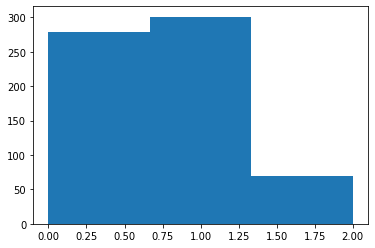

In [216]:
plt.clf()
plt.hist(game_results, bins=3)
plt.show()

Unsurprisingly, a random strategy versus a keep-first-roll strategy produce roughly the same amounts of wins as losses. Next we'll try making an algorithm that can understand game states, and have it learn a policy for optimal play behaviour.